# Set up NB

In [1]:
# %gui qt
%matplotlib notebook

import sys
import os
import time
import logging
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

In [78]:
import qcodes as qc

from qcodes.instrument.parameter import Parameter

from pytopo.mplplots import init_nb_plotting; reload(init_nb_plotting)
from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots

from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station
from pytopo.qctools.dataset2 import select_experiment
from pytopo.qctools.measurement import MeasurementExt

from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

# Initialize

## global settings

In [3]:
SAMPLE = 'Cq334'

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

qc.dataset.database.initialise_database()

## Create instruments

### Physical instruments

In [62]:
inst_list = []

from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL5::INSTR")
inst_list.append(ivvi)

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "TCPIP::169.254.4.62::INSTR", force_new_instance=True)
key2 = create_inst(Keysight_34465A, "key2", "TCPIP::169.254.4.61::INSTR", force_new_instance=True)
inst_list.append(key1)
inst_list.append(key2)

from qcodes.instrument_drivers.stanford_research.SR860 import SR860
lockin1 = create_inst(SR860, "lockin1", "GPIB0::3::INSTR")
inst_list.append(lockin1)


for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(2)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(20)

station = qc.Station(*inst_list)

Instrument ivvi already exists.
Instrument key1 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.13s
Instrument key2 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.11s
Instrument lockin1 already exists.


d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:578: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:590: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


### Virtual instruments

#### IVVI Rack

In [63]:
from pytopo import ivvi as ivvi_ext; reload(ivvi_ext)
from pytopo.ivvi import IVVISetup

SD_current_resistance = 12e3 + 10e3 + 3.4e3
SD_dac_multiplier = 1e-2
SD_lockin_volt_multiplier = 1e-4
SD_current_gain = 1e7

ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
station = add2station(station, ivvi_setup)


ivvi_setup.add_dac_voltage_src('SD', 
                               dac_number=4, 
                               multiplier=SD_dac_multiplier)

ivvi_setup.add_voltage_src('SD_lockin', 
                           param=lockin1.amplitude, 
                           multiplier=SD_lockin_volt_multiplier)

ivvi_setup.add_current_meas('SD', 
                            voltage_param=key1.volt, 
                            gain=SD_current_gain)

ivvi_setup.add_dac_voltage_src('T1', 
                               dac_number=9, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T2', 
                               dac_number=10, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T3', 
                               dac_number=8, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T4', 
                               dac_number=11, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('R2', 
                               dac_number=7, 
                               multiplier=0.1)
ivvi_setup.add_dac_voltage_src('G_fine', 
                               dac_number=16, 
                               multiplier=0.01)
ivvi_setup.add_dac_voltage_src('G_coarse', 
                               dac_number=15, 
                               multiplier=1)

ivvi_setup.SD_lockin_voltage(1e-5)

def print_IVVI_dac_list():
    for i in range(16):
        print('IVVI DAC #{} at {} mV'.format(i+1, ivvi.get('dac{}'.format(i+1))))

Instrument ivvi_setup already exists.


#### Test IVVI with sample sim

In [22]:
voltage = np.linspace(-10e-3, 10e-3, 11)
current = np.zeros_like(voltage)
lockin_mag = np.zeros_like(voltage)
lockin_phase = np.zeros_like(voltage)

for i, v in enumerate(voltage):
    ivvi_setup.SD_voltage(v)
    current[i] = ivvi_setup.SD_current()
    z = lockin1.X() + 1j * lockin1.Y()
    lockin_mag[i] = np.abs(z)
    lockin_phase[i] = np.angle(z, deg=True)

In [38]:
corr_bias = ivvi_setup.corrected_bias(
    current, 
    voltage, 
    SD_current_resistance
)

dIdV = ivvi_setup.corrected_dIdV(
    lockin_mag, 
    lockin_dV=1e-4, 
    current_gain=1e7,
)

<IPython.core.display.Javascript object>


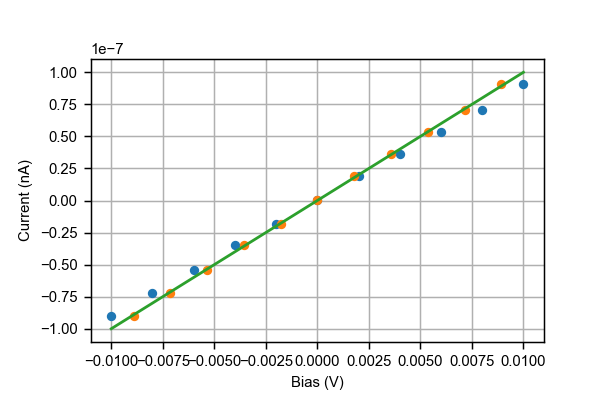

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(voltage, current, 'o')
ax.plot(corr_bias, current, 'o')
ax.plot(voltage, voltage/100e3)
ax.set_xlabel('Bias (V)')
ax.set_ylabel('Current (nA)')
ax.grid()

## Set save Defaults

In [83]:
ivvi.set_dacs_zero()
ivvi_setup.SD_lockin_voltage(1e-5)

# Double Dot Experiment

In [87]:
ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(0)

In [93]:
print_IVVI_dac_list()

IVVI DAC #1 at 0.03051804379333589 mV
IVVI DAC #2 at 0.03051804379333589 mV
IVVI DAC #3 at 0.03051804379333589 mV
IVVI DAC #4 at 0.03051804379333589 mV
IVVI DAC #5 at 0.03051804379333589 mV
IVVI DAC #6 at 0.03051804379333589 mV
IVVI DAC #7 at 0.03051804379333589 mV
IVVI DAC #8 at 0.03051804379333589 mV
IVVI DAC #9 at 0.03051804379333589 mV
IVVI DAC #10 at 0.03051804379333589 mV
IVVI DAC #11 at 0.03051804379333589 mV
IVVI DAC #12 at 0.03051804379333589 mV
IVVI DAC #13 at 0.03051804379333589 mV
IVVI DAC #14 at 0.03051804379333589 mV
IVVI DAC #15 at 0.03051804379333589 mV
IVVI DAC #16 at 0.03051804379333589 mV


## Pinch-off curves

In [127]:
voltages = np.linspace(0, -0.5, 501)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(21.2)
ivvi_setup.SD_voltage(1e-3)
sweep_direction = Parameter('sweep_direction', get_cmd=None, set_cmd=None)
exp = select_experiment('DC_CSD', SAMPLE)

gates = [ivvi_setup.R2_voltage] # [ivvi_setup.T2_voltage, ivvi_setup.T3_voltage, ivvi_setup.T4_voltage]
for gate in gates:
    
    # set all gates to zero.
    for g in [
        ivvi_setup.T2_voltage, 
        ivvi_setup.T3_voltage, 
        ivvi_setup.T4_voltage,
        ivvi_setup.R2_voltage,
    ]:
        g(0)
    
    # now meaure pinch-off (up and down) for each gate in gates
    meas = MeasurementExt(station, exp=exp,
                          soft_sweep_params=[
                              gate,
                              sweep_direction,
                          ],
                          soft_data_params=[
                              lockin1.X,
                              lockin1.Y,
                              ivvi_setup.SD_current,
                          ])

    meas.write_period = 1

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for direction in [0,1]:
            sweep_direction(direction)

            volt = voltages
            if direction:
                volt = voltages[::-1]

            for g in volt:
                gate(g)
                datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1142


ValueError: ('-2010.0 is invalid: must be between -2000.0 and 2000.0 inclusive; Parameter: ivvi.dac7', 'setting ivvi_dac7 to -2010.0', 'setting ivvi_setup_R2_voltage to -0.201')

## Coulomb blockade

In [136]:
T2_vals = np.linspace(-0.2, -0.4, 6)
T3_vals = np.linspace(-0.3, -0.5, 6)
PG_vals = np.linspace(0, 1e-1, 101)
PG = ivvi_setup.R2_voltage # _fine_voltage

ivvi_setup.R2_voltage(0)
ivvi_setup.G_fine_voltage(0)
ivvi_setup.T4_voltage(0)
ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(21.2)

exp = select_experiment('Coulomb_blockade_scan', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T2_voltage,
                          ivvi_setup.T3_voltage,
                          PG,
                      ],
                      soft_data_params=[
                          lockin1.X,
                          lockin1.Y,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for t2 in T2_vals:
        ivvi_setup.T2_voltage(t2)
        
        for t3 in T3_vals:
            ivvi_setup.T3_voltage(t3)
            
            for pg in PG_vals:
                PG(pg)
                
                datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1146


In [133]:
ivvi_setup.R2_voltage(0)

KeyboardInterrupt: 

In [132]:
ivvi_setup.R2_voltage(0.1)

KeyboardInterrupt: 

0.091554131380235049

## Diamond scan

In [ ]:
PG_vals = np.linspace(0, 1e-3, 101)
PG = ivvi_setup.R2_voltage
bias_vals = np.linspace(-0.4e-3, 0.4e-3, 161)

ivvi_setup.T2_voltage(-0.3)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(-0.3)

ivvi_setup.R2_voltage(0)
ivvi_setup.G_fine_voltage(0)
ivvi_setup.SD_voltage(0)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(21.2)

exp = select_experiment('Diamond_scan', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                          PG,
                      ],
                      soft_data_params=[
                          lockin1.X,
                          lockin1.Y,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for pg in PG_vals:
        PG(pg)
            
        for bias in bias_vals:
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1147


## DC CSD 

In [123]:
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.44)
ivvi_setup.T4_voltage(-0.3)

TG = ivvi_setup.T4_voltage
TG_vals = np.linspace(-0.25, -0.35, 3)

ivvi_setup.SD_voltage(250e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(21.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T4_voltage,
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          lockin1.X,
                          ivvi_setup.SD_current,                          
                      ])

meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for tg in TG_vals:
        TG(tg)
        
        print(time.strftime('%Y-%m-%d %H:%M:%S') + ' setting {} to {} V'.format(TG, tg))
    
        for r2 in np.linspace(0, 1e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0, 1e-3, 51):
                ivvi_setup.G_fine_voltage(pg)

                datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1138
2018-07-20 16:09:49 setting ivvi_setup_T4_voltage to -0.25 V
2018-07-20 16:33:33 setting ivvi_setup_T4_voltage to -0.3 V
2018-07-20 16:57:17 setting ivvi_setup_T4_voltage to -0.35 V


KeyboardInterrupt: 

In [69]:
1.1 / (21 * 16) * 51**2

8.51517857142857

In [108]:
%%timeit
lockin1.X()

6.29 ms ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [114]:
key1.NPLC(10)

In [110]:
%%timeit
key1.volt()

51.3 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
key1.volt()

0.00882813757